# Mixture Models


Notebook to play around with the Iris dataset and Mixture Models


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
iris_df = sns.load_dataset("iris")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


<IPython.core.display.Javascript object>

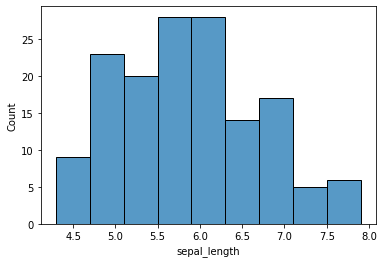

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(iris_df.sepal_length)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_iris_df = scaler.fit_transform(iris_df.drop(columns=["species"]))
scaled_iris_df = pd.DataFrame(scaled_iris_df, columns=iris_df.columns[:4])
scaled_iris_df["species"] = iris_df["species"]
scaled_iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.900681,1.019004,-1.340227,-1.315444,setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,setosa
2,-1.385353,0.328414,-1.397064,-1.315444,setosa
3,-1.506521,0.098217,-1.283389,-1.315444,setosa
4,-1.021849,1.249201,-1.340227,-1.315444,setosa
...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,virginica
146,0.553333,-1.282963,0.705921,0.922303,virginica
147,0.795669,-0.131979,0.819596,1.053935,virginica
148,0.432165,0.788808,0.933271,1.448832,virginica


<IPython.core.display.Javascript object>

In [5]:
scaled_iris_df.groupby(["species"]).agg(
    mean_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="mean"),
    std_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="std"),
    mean_petal_length=pd.NamedAgg(column="petal_length", aggfunc="mean"),
    std_petal_length=pd.NamedAgg(column="petal_length", aggfunc="std"),
    mean_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="mean"),
    std_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="std"),
    mean_petal_width=pd.NamedAgg(column="petal_width", aggfunc="mean"),
    std_petal_width=pd.NamedAgg(column="petal_width", aggfunc="std"),
)

,mean_sepal_length,std_sepal_length,mean_petal_length,std_petal_length,mean_sepal_width,std_sepal_width,mean_petal_width,std_petal_width
species,,,,,,,,
setosa,-1.014579,0.427104,-1.304987,0.098706,0.853263,0.872594,-1.254893,0.138721
versicolor,0.112282,0.625434,0.285324,0.267085,-0.661432,0.722354,0.166734,0.260306
virginica,0.902297,0.770482,1.019663,0.313683,-0.191831,0.742377,1.088159,0.361528


<IPython.core.display.Javascript object>

In [6]:
n_clusters = 4
n_observations = len(scaled_iris_df.sepal_length)
with pm.Model() as model:
    sl_sigmas = pm.HalfNormal("sl_sigmas", sigma=1, shape=n_clusters)
    pl_sigmas = pm.HalfNormal("pl_sigmas", sigma=1, shape=n_clusters)
    sw_sigmas = pm.HalfNormal("sw_sigmas", sigma=1, shape=n_clusters)
    pw_sigmas = pm.HalfNormal("pw_sigmas", sigma=1, shape=n_clusters)

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    sl_means = pm.Normal("sl_means", [0] * n_clusters, sd=1, shape=n_clusters)
    pl_means = pm.Normal("pl_means", [0] * n_clusters, sd=1, shape=n_clusters)
    sw_means = pm.Normal("sw_means", [0] * n_clusters, sd=1, shape=n_clusters)
    pw_means = pm.Normal("pw_means", [0] * n_clusters, sd=1, shape=n_clusters)

    y_sl = pm.Normal(
        "y_sl",
        mu=sl_means[category],
        sd=sl_sigmas[category],
        observed=scaled_iris_df.sepal_length,
    )
    y_pl = pm.Normal(
        "y_pl",
        mu=pl_means[category],
        sd=pl_sigmas[category],
        observed=scaled_iris_df.petal_length,
    )
    y_sw = pm.Normal(
        "y_sw",
        mu=sw_means[category],
        sd=sw_sigmas[category],
        observed=scaled_iris_df.sepal_width,
    )
    y_pw = pm.Normal(
        "y_pw",
        mu=pw_means[category],
        sd=pw_sigmas[category],
        observed=scaled_iris_df.petal_width,
    )

    trace = pm.sample(10000)

<ipython-input-6-e3f96e122ee7>:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pw_means, sw_means, pl_means, sl_means, p, pw_sigmas, sw_sigmas, pl_sigmas, sl_sigmas]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 329 seconds.
There were 9991 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32749999999854607, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


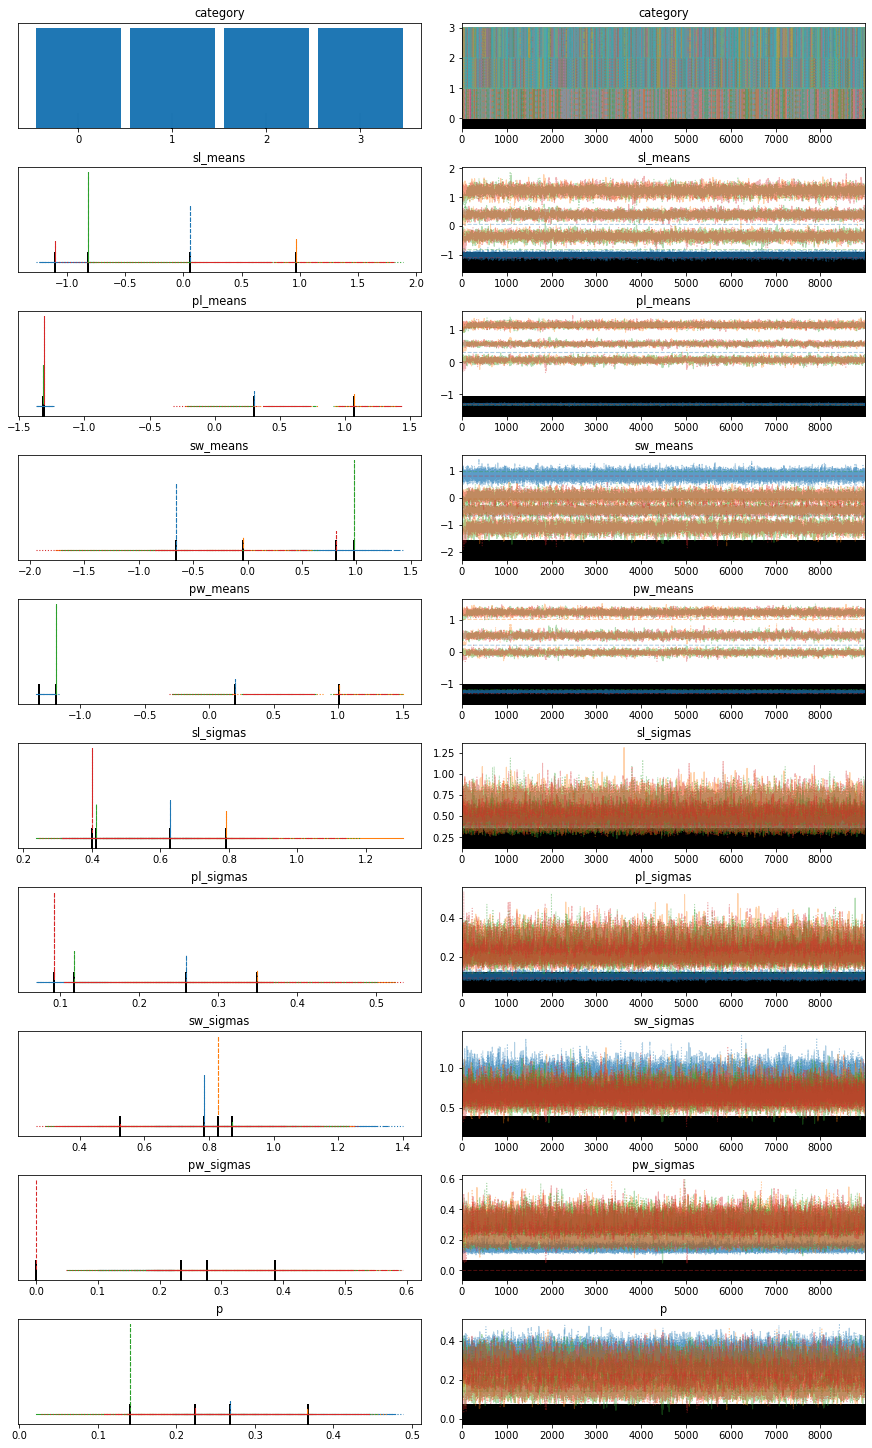

<IPython.core.display.Javascript object>

In [7]:
with model:
    pm.plot_trace(trace[1000:])

In [8]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=6000, combine=False)[3][200])
]
iris_df["group"] = groups
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species,group
0,5.1,3.5,1.4,0.2,setosa,Group 1
1,4.9,3.0,1.4,0.2,setosa,Group 1
2,4.7,3.2,1.3,0.2,setosa,Group 1
3,4.6,3.1,1.5,0.2,setosa,Group 1
4,5.0,3.6,1.4,0.2,setosa,Group 1
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,Group 4
146,6.3,2.5,5.0,1.9,virginica,Group 3
147,6.5,3.0,5.2,2.0,virginica,Group 4
148,6.2,3.4,5.4,2.3,virginica,Group 4


<IPython.core.display.Javascript object>

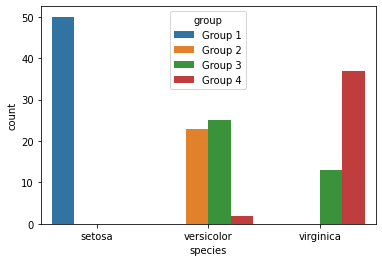

<IPython.core.display.Javascript object>

In [9]:
plot_df = (
    iris_df.groupby(["species", "group"])
    .count()[["sepal_length"]]
    .reset_index()
    .rename(columns={"sepal_length": "count"})
)
_ = sns.barplot(data=plot_df, x="species", y="count", hue="group")

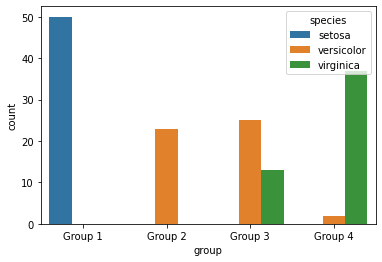

<IPython.core.display.Javascript object>

In [10]:
_ = sns.barplot(data=plot_df, x="group", y="count", hue="species")